# KSS 데이터셋 전처리 과정
음향모델 tacotron2 와 보코더 waveglow 학습 및 추론을 위한 전처리 과정입니다.

## KSS 데이터 EDA
- 텍스트 길이에 따른 분포 시각화
- 음성 길이에 따른 분포 시각화 
- 텍스트-음성 길이 간 상관성

In [5]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
from mpl_toolkits.mplot3d import Axes3D
import numpy as np # linear algebra
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline

Data preview:
     Audio Path     Original Text (Korean)   Normalized Text (Korean)  \
0  1/1_0000.wav     그는 괜찮은 척하려고 애쓰는 것 같았다.     그는 괜찮은 척하려고 애쓰는 것 같았다.   
1  1/1_0001.wav  그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.  그녀의 사랑을 얻기 위해 애썼지만 헛수고였다.   
2  1/1_0002.wav                 용돈을 아껴 써라.                 용돈을 아껴 써라.   
3  1/1_0003.wav             그는 아내를 많이 아낀다.             그는 아내를 많이 아낀다.   
4  1/1_0004.wav               그 애 전화번호 알아?               그 애 전화번호 알아?   

                     Phoneme Representation (Korean) Duration  \
0    그는 괜찮은 척하려고 애쓰는 것 같았다.      3.5   
1  그녀의 사랑을 얻기 위해 애썼지만 헛수고ᄋ...      4.0   
2                               용돈을 아껴 써라.      1.8   
3                       그는 아내를 많이 아낀다.      2.3   
4                            그 애 전화번호 알아?      1.3   

                Translated Text (English)  
0  He seemed to be pretending to be okay.  
1        I tried in vain to win her love.  
2                 Save y

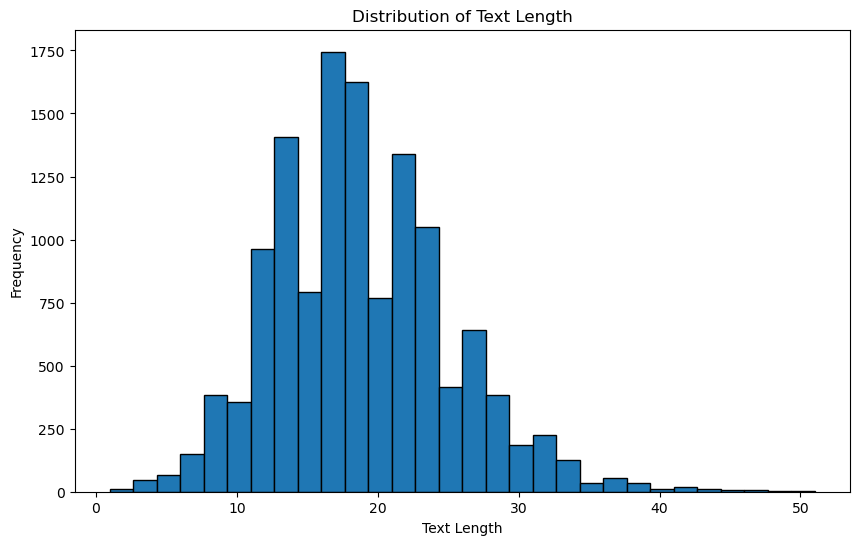

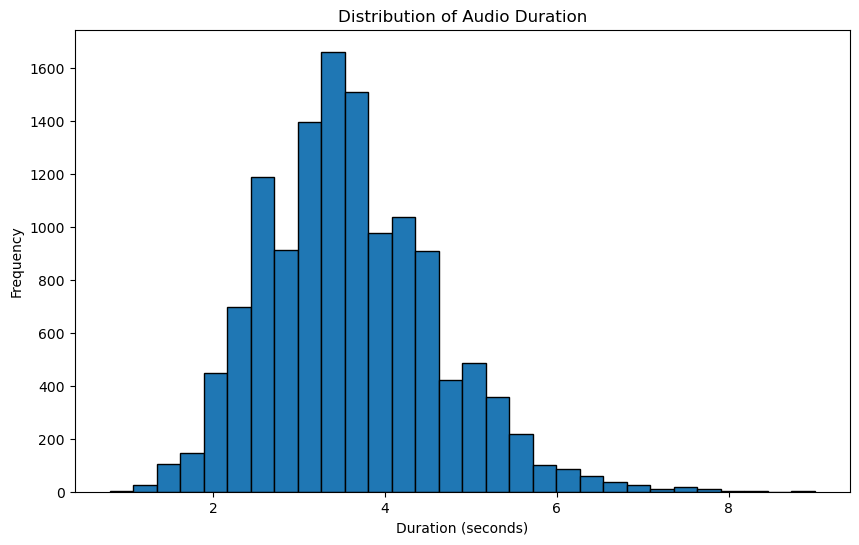

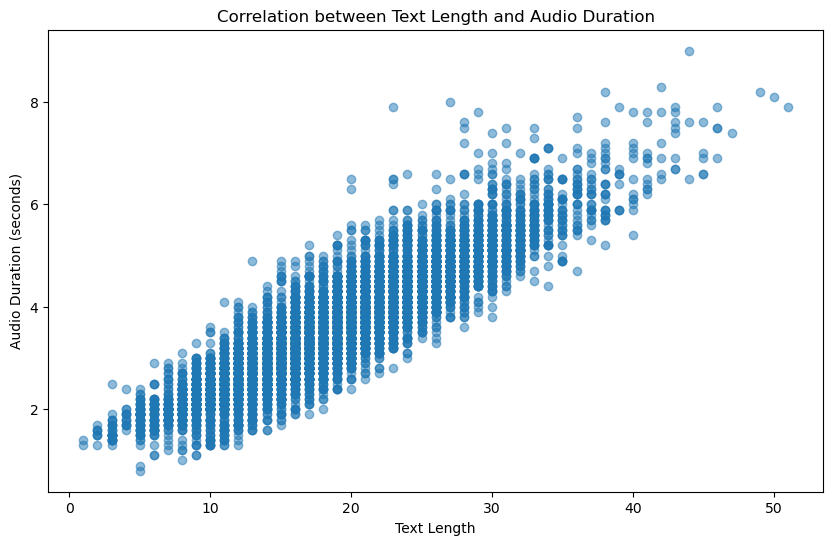

In [6]:
# 데이터 파일 경로
transcript_file = 'Dataset/transcript.v.1.4.txt'

# 데이터 읽기
with open(transcript_file, 'r', encoding='utf-8') as f:
    transcripts = f.readlines()

# 데이터 프레임 생성
columns = [
    "Audio Path",
    "Original Text (Korean)",
    "Normalized Text (Korean)",
    "Phoneme Representation (Korean)",
    "Duration",
    "Translated Text (English)"
]
data = [line.strip().split('|') for line in transcripts]
df = pd.DataFrame(data, columns=columns)

# 데이터 확인
print("Data preview:")
print(df.head())

# 텍스트 길이 분석
df['Text Length'] = df['Original Text (Korean)'].apply(len)

# 텍스트 길이 분포 시각화
plt.figure(figsize=(10, 6))
plt.hist(df['Text Length'], bins=30, edgecolor='k')
plt.title("Distribution of Text Length")
plt.xlabel("Text Length")
plt.ylabel("Frequency")
plt.show()

# 오디오 길이 분석
df['Duration'] = df['Duration'].astype(float)  # 숫자형으로 변환

plt.figure(figsize=(10, 6))
plt.hist(df['Duration'], bins=30, edgecolor='k')
plt.title("Distribution of Audio Duration")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency")
plt.show()

# 텍스트-오디오 길이 상관관계
plt.figure(figsize=(10, 6))
plt.scatter(df['Text Length'], df['Duration'], alpha=0.5)
plt.title("Correlation between Text Length and Audio Duration")
plt.xlabel("Text Length")
plt.ylabel("Audio Duration (seconds)")
plt.show()


## preprocessing
### 원본 필드
- A. Audio file path
- B. Original script
- C. Expanded script
- D. Decomposed script
- E. Audio duration (seconds)
- F. English translation

### 음향모델(Tacotron2) 학습에 필요한 필드
- A. Audio file path
- C. Expanded script

#### 전처리 방법
1. 학습용, 추론용 데이터 생성
    - A와 C 기반으로 train.txt, val.txt, test.txt 생성
    - 데이터 랜덤 분할 (8:1:1)
2. 오디오 파일 경로를 절대 경로로 변환
3. 오디오 파일 sampling rate 변환
    - Tacotron2의 경우 22050 sampling rate로 학습

### 보코더(WaveGlow) 학습에 필요한 필드
- A. Audio file path

#### 전처리 방법
1. 학습용, 추론용 데이터 생성
    - 음향 모델 데이터셋을 기반으로, A 필드만 남겨 새로 저장



In [7]:
import os
import random

# 파일 경로 설정
base_dir = "Dataset"
transcript_path = os.path.join(base_dir, "transcript.v.1.4.txt")
audio_base_path = os.path.join(base_dir, "kss")

output_dir = "Dataset/tr_vl_ts"
os.makedirs(output_dir, exist_ok=True)

# Tacotron 학습 데이터 경로
output_train = os.path.join(output_dir, "train.txt")
output_val = os.path.join(output_dir, "val.txt")
output_test = os.path.join(output_dir, "test.txt")

# WaveGlow 학습 데이터 경로
output_train_waveglow = os.path.join(output_dir, "train_vocoder.txt")
output_val_waveglow = os.path.join(output_dir, "val_vocoder.txt")
output_test_waveglow = os.path.join(output_dir, "test_vocoder.txt")

# 전처리 함수
def preprocess_transcript(transcript_path, audio_base_path, train_ratio=0.8, val_ratio=0.1):
    with open(transcript_path, "r", encoding="utf-8") as f:
        lines = f.readlines()

    data_tacotron = []
    data_waveglow = []
    
    for line in lines:
        parts = line.strip().split("|")
        if len(parts) < 3:  # 필드가 부족한 경우 무시
            continue
        relative_path, expanded_script = parts[0], parts[2]  # 오디오 경로와 확장된 텍스트
        absolute_path = os.path.join(audio_base_path, relative_path)
        if os.path.exists(absolute_path):  # 오디오 파일 존재 확인
            data_tacotron.append(f"{absolute_path}|{expanded_script}\n")
            data_waveglow.append(f"{absolute_path}\n")

    # 데이터를 랜덤하게 섞음
    combined_data = list(zip(data_tacotron, data_waveglow))
    random.shuffle(combined_data)
    data_tacotron, data_waveglow = zip(*combined_data)

    # 분할 비율에 따라 데이터셋 나누기
    train_size = int(len(data_tacotron) * train_ratio)
    val_size = int(len(data_tacotron) * val_ratio)
    
    train_tacotron = data_tacotron[:train_size]
    val_tacotron = data_tacotron[train_size:train_size + val_size]
    test_tacotron = data_tacotron[train_size + val_size:]
    
    train_waveglow = data_waveglow[:train_size]
    val_waveglow = data_waveglow[train_size:train_size + val_size]
    test_waveglow = data_waveglow[train_size + val_size:]

    return (train_tacotron, val_tacotron, test_tacotron, 
            train_waveglow, val_waveglow, test_waveglow)

# 전처리 실행
(train_tacotron, val_tacotron, test_tacotron, 
 train_waveglow, val_waveglow, test_waveglow) = preprocess_transcript(transcript_path, audio_base_path)

# 결과 저장
with open(output_train, "w", encoding="utf-8") as train_file:
    train_file.writelines(train_tacotron)
with open(output_val, "w", encoding="utf-8") as val_file:
    val_file.writelines(val_tacotron)
with open(output_test, "w", encoding="utf-8") as test_file:
    test_file.writelines(test_tacotron)

with open(output_train_waveglow, "w", encoding="utf-8") as train_file:
    train_file.writelines(train_waveglow)
with open(output_val_waveglow, "w", encoding="utf-8") as val_file:
    val_file.writelines(val_waveglow)
with open(output_test_waveglow, "w", encoding="utf-8") as test_file:
    test_file.writelines(test_waveglow)

print(f"Tacotron Train set saved to {output_train}")
print(f"Tacotron Validation set saved to {output_val}")
print(f"Tacotron Test set saved to {output_test}")
print(f"WaveGlow Train set saved to {output_train_waveglow}")
print(f"WaveGlow Validation set saved to {output_val_waveglow}")
print(f"WaveGlow Test set saved to {output_test_waveglow}")


Tacotron Train set saved to Dataset/tr_vl_ts\train.txt
Tacotron Validation set saved to Dataset/tr_vl_ts\val.txt
Tacotron Test set saved to Dataset/tr_vl_ts\test.txt
WaveGlow Train set saved to Dataset/tr_vl_ts\train_vocoder.txt
WaveGlow Validation set saved to Dataset/tr_vl_ts\val_vocoder.txt
WaveGlow Test set saved to Dataset/tr_vl_ts\test_vocoder.txt


In [10]:
!pip install librosa

  Using cached librosa-0.10.2.post1-py3-none-any.whl.metadata (8.6 kB)
  Using cached audioread-3.0.1-py3-none-any.whl.metadata (8.4 kB)
  Using cached pooch-1.8.2-py3-none-any.whl.metadata (10 kB)
  Using cached soxr-0.5.0.post1-cp312-abi3-win_amd64.whl.metadata (5.6 kB)
Using cached librosa-0.10.2.post1-py3-none-any.whl (260 kB)
Using cached audioread-3.0.1-py3-none-any.whl (23 kB)
Using cached pooch-1.8.2-py3-none-any.whl (64 kB)
   ---------------------------------------- 0.0/1.0 MB ? eta -:--:--
   ---------------------------------------- 1.0/1.0 MB 9.7 MB/s eta 0:00:00
Using cached soxr-0.5.0.post1-cp312-abi3-win_amd64.whl (164 kB)


In [11]:
import librosa
import soundfile as sf
import os
from glob import glob

In [12]:
# 데이터 경로
dataset_path = "Dataset/kss"
target_sr = 22050  # 목표 샘플링 레이트

def resample_audio_files(dataset_path, target_sr):
    audio_files = glob(os.path.join(dataset_path, "**/*.wav"), recursive=True)
    print(f"Found {len(audio_files)} audio files.")
    
    for file_path in audio_files:
        try:
            # 오디오 파일 로드
            audio, sr = librosa.load(file_path, sr=None)
            if sr != target_sr:
                print(f"Resampling {file_path}: {sr} -> {target_sr}")
                # 리샘플링
                audio_resampled = librosa.resample(audio, orig_sr=sr, target_sr=target_sr)
                # 덮어쓰기 저장
                sf.write(file_path, audio_resampled, target_sr)
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

for i in range (1,5):
    d_path = os.path.join(dataset_path, str(i))
    resample_audio_files(d_path, target_sr)

Found 1040 audio files.
Resampling Dataset/kss\1\1_0000.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0001.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0002.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0003.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0004.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0005.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0006.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0007.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0008.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0009.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0010.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0011.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0012.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0013.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0014.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0015.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0016.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0017.wav: 44100 -> 22050
Resampling Dataset/kss\1\1_0018.wav: 441